# Content and Objective

+ Simulate (discrete-time) white gaussian process
+ Show that histogram of amplitudes is gaussian
+ Get moments and demonstrate that they agree with theoretical values
+ Estimate acf and provide use-case when estimating an unknown delay by using correlation

# Import

In [1]:
# importing
import numpy as np
import shutil

import matplotlib.pyplot as plt
import matplotlib

In [4]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True if shutil.which('latex') else False)

matplotlib.rc('figure', figsize=(14, 6) )

# Simulation of Gaussian Process (White Gaussian Noise)

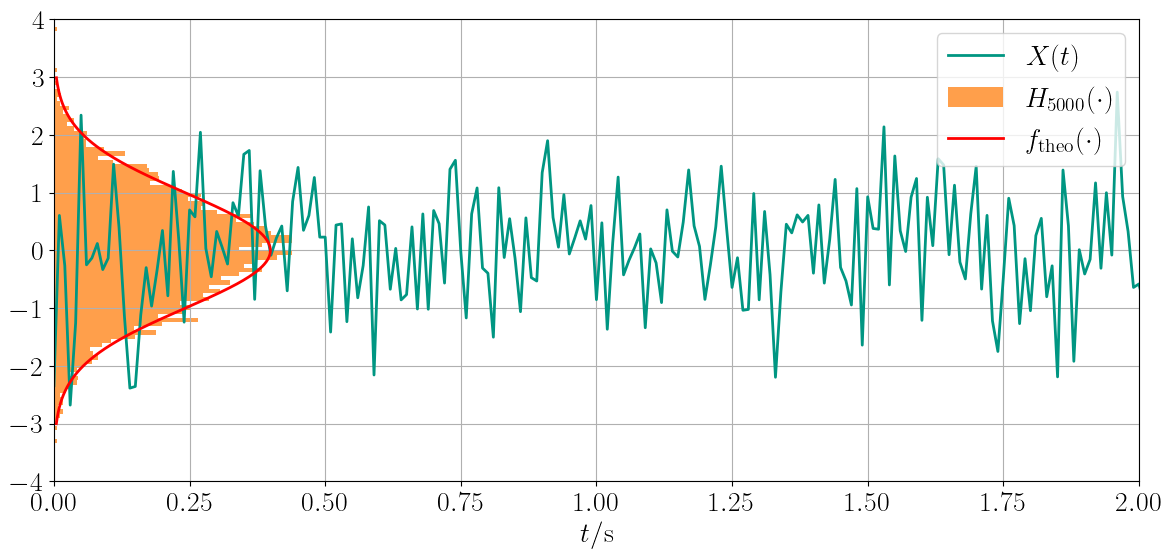

In [8]:
#  showing example in Jondral 02, WT

# parameters: sample time and number of samples
t_sample = .01
N_samples = 5000

# vector of times
t = np.arange( 0, N_samples * t_sample, t_sample )

# parameters of gaussian
mu = 0
sigma2 = 1    

# sample random white gaussian
X_sim = np.random.randn( len( t ) )    

# get theoretical pdf
x = np.arange( -3*sigma2, 3*sigma2, .01 )    
f_theo_norm = 1 / np.sqrt( 2*np.pi*sigma2 ) * np.exp( - x**2 / 2 / sigma2 )


# plotting
plt.plot( t, X_sim, c=(0,0.59,0.51), linewidth=2.0, label='$X(t)$')    
plt.hist( X_sim, 100, color='#ff7f0e', density=1, orientation='horizontal', label=r'$H_{{{}}}(\cdot)$'.format(N_samples), alpha=0.75)    
plt.plot( f_theo_norm, x, color='r', linewidth = 2.0, label=r'$f_{\mathrm{theo}}(\cdot)$' )

plt.xlabel('$t/\\mathrm{s}$')
plt.grid( True )
plt.legend( loc = 'upper right' )
plt.xlim( ( 0, 200*t_sample ) )
plt.ylim( (-4,4) )
#plt.savefig('wgn_sim_theo.pdf', bbox_inches='tight')

# Showing Moments in $\Omega$ and Time ("Check Ergodicity")

In [9]:
# print moments of the process and the realization
print( ' E(X) = {}, \tergodic = {:2.2f}'.format( mu, np.mean( X_sim ) ) ) 
print( ' E(X^2) = {}, \tergodic = {:2.2f}'.format( mu**2 + sigma2, np.mean( X_sim**2 ) ) )
print( ' E(X^3) = {}, \tergodic = {:2.2f}'.format( mu**3 + 3 * mu * sigma2, np.mean( X_sim**3 ) ) )
print( ' E(X^4) = {}, \tergodic = {:2.2f}'.format( mu*4 + 6 * mu**2 * sigma2 + 3 * sigma2**2, np.mean( X_sim**4 ) ) )

 E(X) = 0, 	ergodic = -0.00
 E(X^2) = 1, 	ergodic = 1.01
 E(X^3) = 0, 	ergodic = -0.04
 E(X^4) = 3, 	ergodic = 3.03


# Estimating ACF $\varphi_{XX}(\tau)$

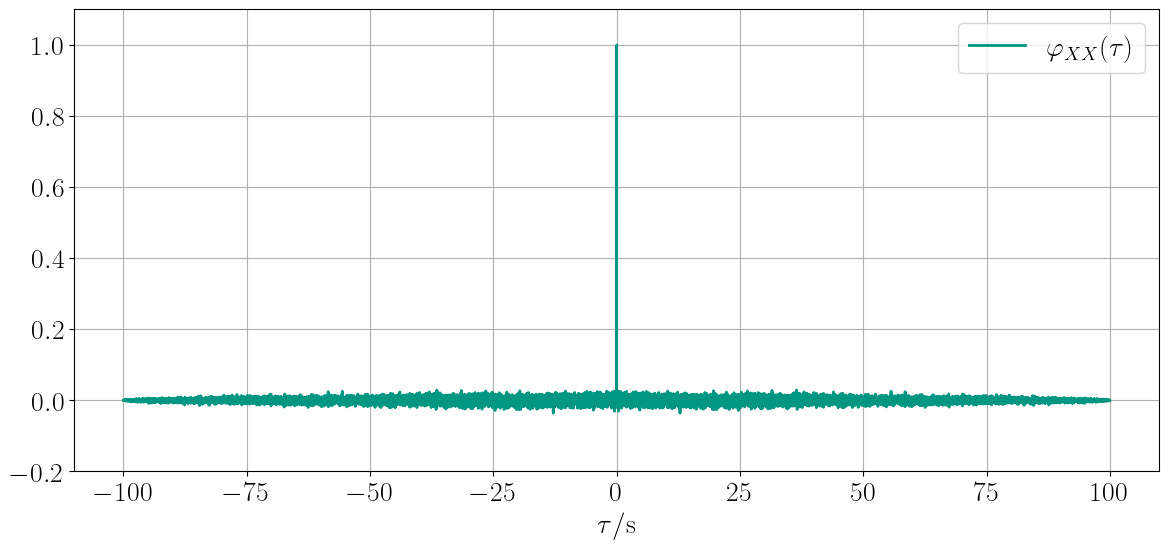

In [28]:
# get acf of realization by correlating in time 
acf = np.correlate( X_sim, X_sim, mode='full' )
acf /= np.max( acf )

# determine vector of sample values
# NOTE: ACF is symmetrical; so, negative values will be observed as well
tau = np.arange( -N_samples * t_sample, (N_samples -1)* t_sample, t_sample )


# plotting
plt.plot( tau, acf, linewidth=2.0, c=(0,0.59,0.51), label='$\\varphi_{XX}(\\tau)$')        

plt.xlabel('$\\tau/\\mathrm{s}$')
plt.grid( True )
plt.legend( loc = 'upper right' )
plt.ylim( (-.2, 1.1) )        
#plt.savefig('wgn_sim_acf.pdf', bbox_inches='tight')

# Application: Find (unknown) Delay of a Signal by Cross-Correlation

In [31]:
# parameters of time
N_samples = 10000
t_sample = .01
t = np.arange( 0, N_samples * t_sample, t_sample )

# delays for correlation
k_corr = np.arange( -len(X_sim), len(X_sim)-1, 1)

# sample white gaussian noise as input signal
mu = 0
sigma2 = 1   
X_sim = np.random.randn( len( t ) )    


# generate random delay and stretch X accordingly
delay = np.random.randint( int( len(t) / 10 ) )
X_extended = np.append( X_sim, np.zeros( (delay, 1) ) )


# add noise to the observation
# NOTE: noise variance may be changed to see possible effects,
# for example, that results are fine up to quite large noise
D2_noise = 100
noise = np.sqrt( D2_noise ) * np.random.randn( len( X_sim ) )

# get output signal be delaying and adding noise
Y_sim = np.roll( X_extended, delay)[: len( X_sim) ] + noise


# cross-correlating received/measured signal Y with input X
corr = np.correlate( Y_sim, X_sim, 'full')

# show max of correlation and actual delay
delay_est = int( ( np.argmax( corr ) - ( len(corr) - 1 ) / 2 ) )


# showing delays (actual and estimated) and SNR
print('Delay as sampled: \t\t\t{}'.format( delay ) )
print('Delay as max. of ccf: \t\t\t{}'.format( delay_est ) )
print('Estimated Signal-to-Noise-Power-Ratio: \t{:2.2f} dB'.format( 10*np.log10( np.linalg.norm(X_sim)**2 / np.linalg.norm(Y_sim-X_sim)**2 ) ) )

Delay as sampled: 			698
Delay as max. of ccf: 			698
Estimated Signal-to-Noise-Power-Ratio: 	-20.15 dB


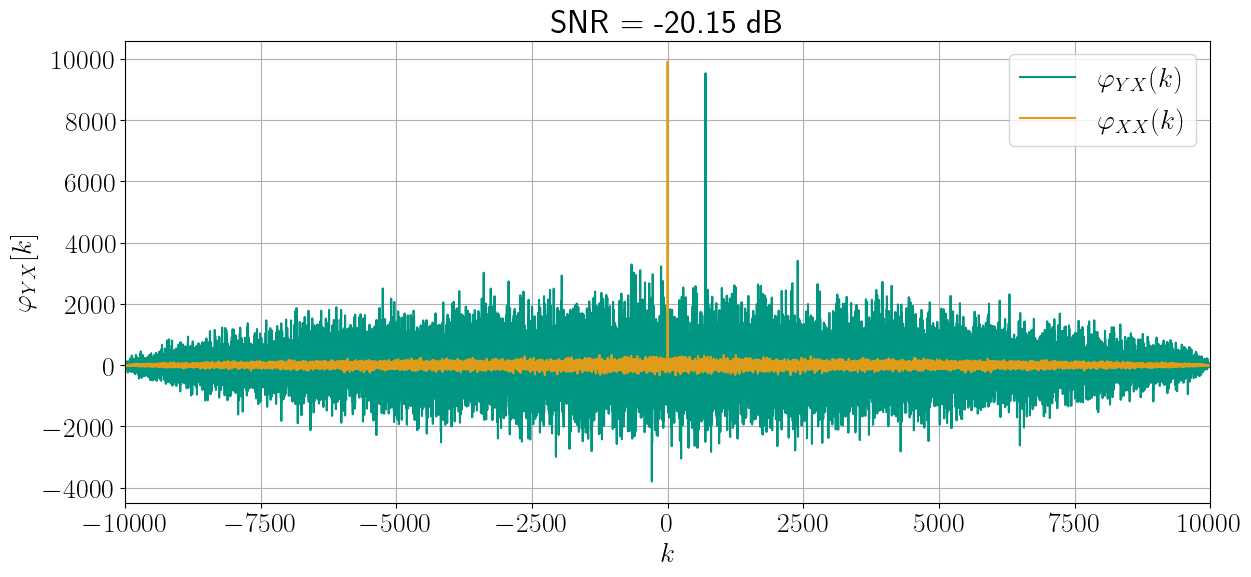

In [34]:
# plotting
plt.plot( k_corr, corr, c=(0,0.59,0.51), label='$\\varphi_{YX}[k]$')
plt.plot( k_corr, np.correlate( X_sim, X_sim, 'full'), c=(0.875,0.61,0.1), label='$\\varphi_{XX}[k]$' )

plt.xlabel('$k$')
plt.ylabel('$\\varphi_{YX}[k]$')
plt.title('SNR = {:2.2f} dB'.format( 10*np.log10( np.linalg.norm(X_sim)**2 / np.linalg.norm(Y_sim-X_sim)**2 ) ) )
plt.xlim( (-10000,10000) )
plt.grid(1)
plt.legend(loc='upper right')
plt.savefig('get_delay.pdf',bbox_inches='tight')

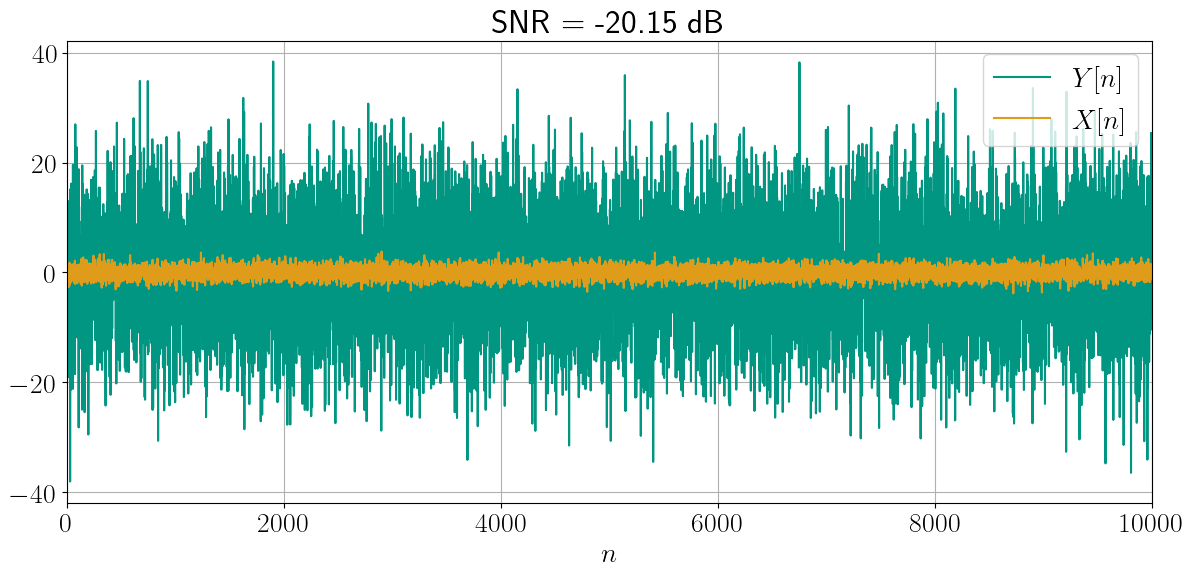

In [37]:
plt.plot( Y_sim , c=(0,0.59,0.51), label='$Y[n]$')
plt.plot( X_sim , c=(0.875,0.61,0.1), label='$X[n]$')

plt.xlabel('$n$')
plt.title('SNR = {:2.2f} dB'.format( 10*np.log10( np.linalg.norm(X_sim)**2 / np.linalg.norm(Y_sim-X_sim)**2 ) ) )
plt.grid(1)
plt.xlim( (0, 10000) )
plt.legend(loc='upper right')
plt.savefig('get_delay_signals.pdf',bbox_inches='tight')